# **Домашнее задание 6**

Обучить сиамскую сеть для верификации лиц на датасете LFW. Библиотеки: [Python, Tensorflow]

## Подключение библиотек

In [ ]:
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.8.2', '1.21.6')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/drive/MyDrive/Colab Notebooks/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Создание Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Создание Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

print("\nTest List:", test_list)

Length of training list: 693
Length of testing list : 78

Test List: {'568': 2, '637': 18, '351': 2, '521': 2, '703': 7, '368': 4, '956': 2, '522': 3, '54': 8, '566': 2, '817': 6, '343': 2, '872': 4, '245': 5, '562': 2, '597': 2, '179': 2, '277': 2, '495': 2, '739': 2, '985': 2, '733': 3, '386': 6, '596': 2, '950': 2, '655': 10, '556': 2, '50': 2, '648': 2, '476': 3, '301': 4, '455': 2, '236': 2, '531': 41, '565': 2, '601': 4, '854': 2, '480': 3, '670': 3, '727': 8, '25': 2, '290': 2, '890': 5, '6': 16, '954': 4, '422': 4, '638': 3, '183': 6, '468': 2, '914': 2, '663': 2, '63': 3, '925': 2, '646': 2, '149': 3, '132': 4, '281': 4, '311': 2, '694': 3, '537': 5, '444': 3, '778': 2, '162': 3, '115': 5, '450': 5, '82': 3, '363': 2, '488': 2, '581': 15, '78': 2, '858': 7, '738': 2, '336': 3, '753': 4, '966': 2, '95': 2, '410': 3, '449': 2}


### Создание Triplets

In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 6151
Number of testing triplets : 552

Examples of triplets:
(('390', '4.jpg'), ('390', '8.jpg'), ('743', '0.jpg'))
(('620', '0.jpg'), ('620', '3.jpg'), ('146', '1.jpg'))
(('99', '2.jpg'), ('99', '3.jpg'), ('572', '1.jpg'))
(('345', '2.jpg'), ('345', '3.jpg'), ('720', '2.jpg'))
(('792', '3.jpg'), ('792', '5.jpg'), ('816', '2.jpg'))


### Создание Batch-Generator

In [ ]:
def get_batch(triplet_list, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Визуализация датасета

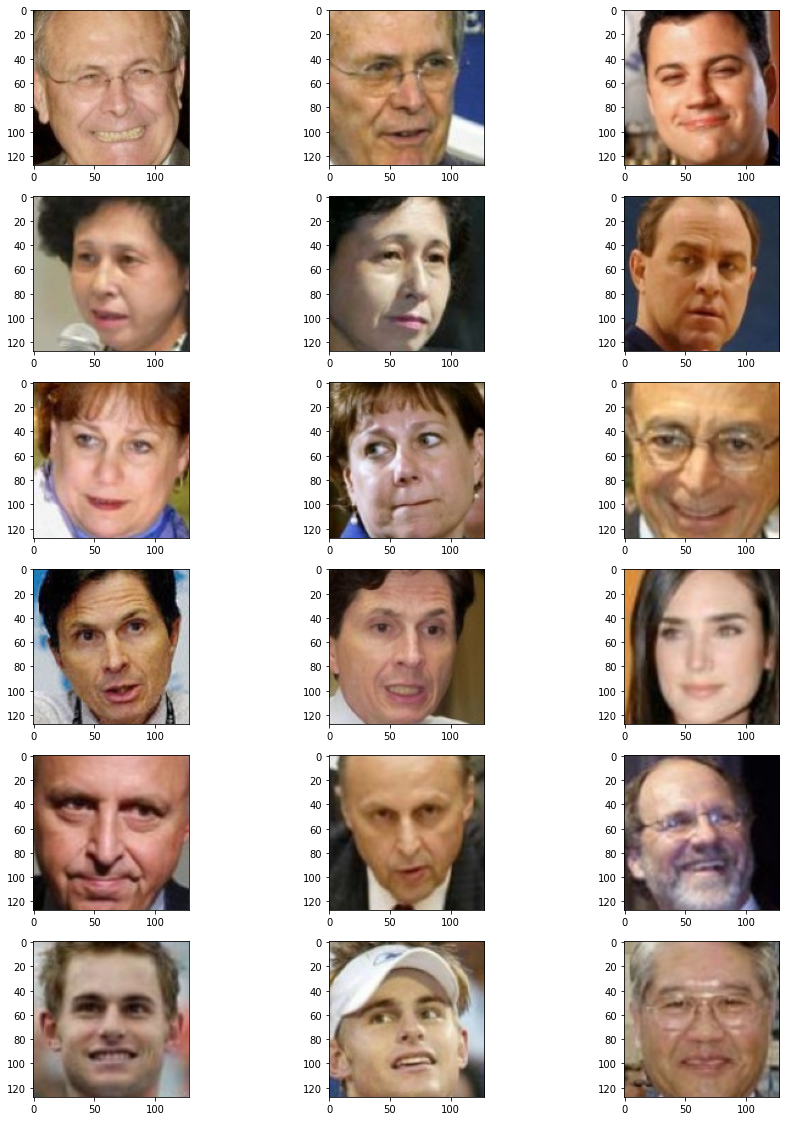

In [ ]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Создание модели сиамской CNN

In [ ]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Encoder

In [ ]:
def get_encoder(input_shape):
    """ Returns the image encoding model """

    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [ ]:
class DistanceLayer(layers.Layer):
    # Вычисление ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # Вычисление ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Создание модели
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 128, 128, 3  0           []                               
                   

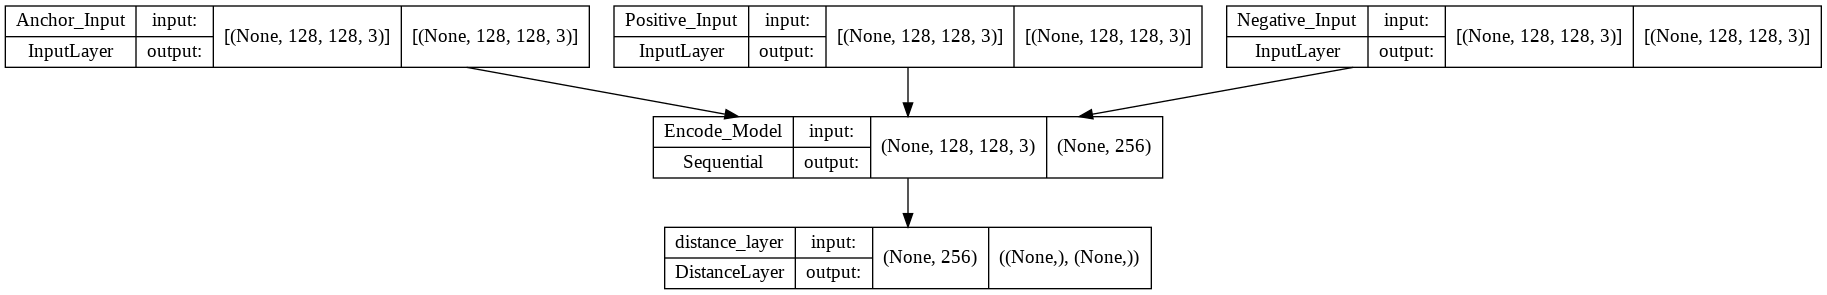

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

### Triplet Loss Function

> Блок с отступами



<img src="https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png" alt="Loss Formula" width="400"/>

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [ ]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Обучение модели

In [ ]:
def test_on_triplets(batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
save_all = False
epochs = 10
batch_size = 128

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Обучение модели на train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Проверка на test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Слхранение весов модели
    if save_all or accuracy>=max_acc:
        siamese_model.save_weights("siamese_model")
        max_acc = accuracy

siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 601 sec)
Loss on train    = 0.51607
Accuracy on test = 0.82065

EPOCH: 2 	 (Epoch done in 69 sec)
Loss on train    = 0.30558
Accuracy on test = 0.86957

EPOCH: 3 	 (Epoch done in 69 sec)
Loss on train    = 0.21496
Accuracy on test = 0.88225

EPOCH: 4 	 (Epoch done in 68 sec)
Loss on train    = 0.15427
Accuracy on test = 0.85870

EPOCH: 5 	 (Epoch done in 69 sec)
Loss on train    = 0.11929
Accuracy on test = 0.85870

EPOCH: 6 	 (Epoch done in 68 sec)
Loss on train    = 0.08846
Accuracy on test = 0.87319

EPOCH: 7 	 (Epoch done in 69 sec)
Loss on train    = 0.07486
Accuracy on test = 0.87862

EPOCH: 8 	 (Epoch done in 69 sec)
Loss on train    = 0.06247
Accuracy on test = 0.89312

EPOCH: 9 	 (Epoch done in 70 sec)
Loss on train    = 0.05921
Accuracy on test = 0.88043

EPOCH: 10 	 (Epoch done in 70 sec)
Loss on train    = 0.04985
Accuracy on test = 0.86957


## Оценка модели


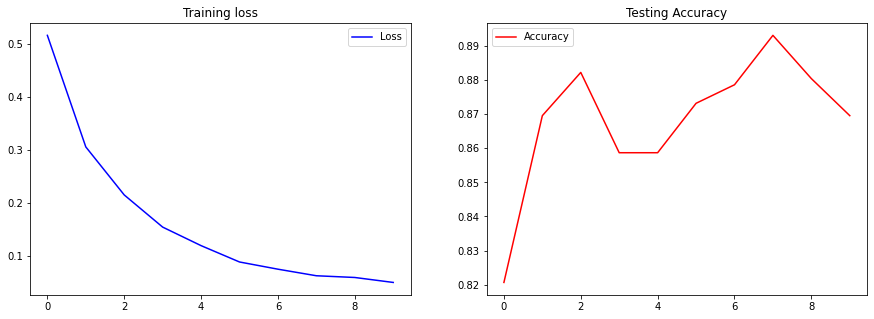

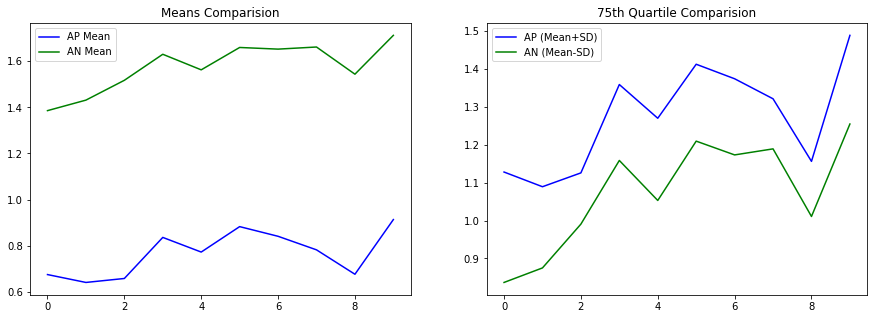

In [ ]:
def plot_metrics(loss, metrics):
    
    accuracy = metrics[:, 0]
    ap_mean  = metrics[:, 1]
    an_mean  = metrics[:, 2]
    ap_stds  = metrics[:, 3]
    an_stds  = metrics[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Визуализация loss
    plt.subplot(121)
    plt.plot(loss, 'b', label='Loss')
    plt.title('Training loss')
    plt.legend()
    
    # Визуализация accuracy
    plt.subplot(122)
    plt.plot(accuracy, 'r', label='Accuracy')
    plt.title('Testing Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(ap_mean, 'b', label='AP Mean')
    plt.plot(an_mean, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    ap_75quartile = (ap_mean+ap_stds)
    an_75quartile = (an_mean-an_stds)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics)
plot_metrics(train_loss, test_metrics)

## Encoder

In [ ]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 lambda_1 (Lambda)           (None, 256)               0         
                                                      

### Матрица ошибок

In [ ]:
def classify_images(face_list1, face_list2, threshold=1.3):

    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.779296875



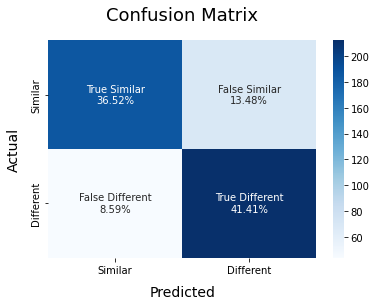

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)